In [ ]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import scipy
import cupy as cp
import gc

In [24]:
estimator = "DeepAR"

test_ids = np.empty((0, ))
test_labels = np.empty((0, 28))
test_forecasts = np.empty((0, 28))

for level in range(1, 13):
    level_dir = f"../result/learning_rate_0.001/level {level}"
    for root, dirs, files in os.walk(level_dir):
        for dir in dirs:
            if dir.startswith(estimator):
                estimator_dir = os.path.join(root, dir)
                for estimator_root, estimator_dirs, estimator_files in os.walk(estimator_dir):
                    for estimator_file in estimator_files:
                        file_path = os.path.join(estimator_root, estimator_file)
                        if estimator_file.startswith('test_labels'):
                            with open(file_path, 'rb') as pickle_file:
                                datas = pd.read_pickle(pickle_file)
                                for data in datas:
                                    arrays = np.array(data)
                                    arrays = np.squeeze(arrays, axis=-1)
                                    arrays = arrays[-28:]
                                    arrays = arrays.reshape(1, -1)
                                    test_labels = np.concatenate((test_labels, arrays), axis=0)
                        if estimator_file.startswith('test_forecasts'):
                            with open(file_path, 'rb') as pickle_file:
                                datas = pd.read_pickle(pickle_file)
                                ids = np.array([data.item_id for data in datas])
                                test_ids = np.concatenate((test_ids, ids), axis=0)
                                arrays = np.array([data.quantile(0.5) for data in datas])
                                test_forecasts = np.concatenate((test_forecasts, arrays), axis=0)

print(test_ids.shape)
print(test_labels.shape)
print(test_forecasts.shape)

(42840,)
(42840, 28)
(42840, 28)


In [ ]:
def create_S(y_id):
   # 필요한 컬럼만 읽기
   sales = pd.read_csv('../data/original/sales_train_validation.csv',
                      usecols=['id', 'state_id', 'store_id', 'cat_id', 'dept_id', 'item_id'])
   
   # 메모리 사용량 줄이기 위해 카테고리 타입 사용
   category_columns = ['state_id', 'store_id', 'cat_id', 'dept_id', 'item_id']
   sales[category_columns] = sales[category_columns].astype('category')
   
   sales['id'] = sales['id'].str.replace('_validation', '', regex=False)
   
   # 미리 unique 값들을 리스트로 변환하여 재사용
   states = list(sales['state_id'].unique())
   stores = list(sales['store_id'].unique())
   cats = list(sales['cat_id'].unique())
   depts = list(sales['dept_id'].unique())
   items = list(sales['item_id'].unique())
   
   states_cats = [f"{state}_{cat}" for state in states for cat in cats]
   states_depts = [f"{state}_{dept}" for state in states for dept in depts]
   stores_cats = [f"{store}_{cat}" for store in stores for cat in cats]
   stores_depts = [f"{store}_{dept}" for store in stores for dept in depts]
   items_states = [f"{item}_{state}" for item in items for state in states]
   items_stores = [f"{item}_{store}" for item in items for store in stores]

   # bool 타입으로 생성 후 나중에 float32로 변환
   S = np.zeros((42840, 30490), dtype=bool)

   for i, id in tqdm(enumerate(y_id), total=len(y_id)):
       if id == 'total':
           S[0, :] = 1            
       elif id in states:
           mask = (sales['state_id'] == id)
           S[i, :] = sales['id'].isin(sales[mask]['id']).values
       elif id in stores:
           mask = (sales['store_id'] == id)
           S[i, :] = sales['id'].isin(sales[mask]['id']).values
       elif id in cats:
           mask = (sales['cat_id'] == id)
           S[i, :] = sales['id'].isin(sales[mask]['id']).values
       elif id in depts:
           mask = (sales['dept_id'] == id)
           S[i, :] = sales['id'].isin(sales[mask]['id']).values
       elif id in states_cats:
           state, cat = id.split('_')
           mask = (sales['state_id'] == state) & (sales['cat_id'] == cat)
           S[i, :] = sales['id'].isin(sales[mask]['id']).values
       elif id in states_depts:
           splitted_id = id.split('_')
           state, dept = splitted_id[0], '_'.join(splitted_id[1:])
           mask = (sales['state_id'] == state) & (sales['dept_id'] == dept)
           S[i, :] = sales['id'].isin(sales[mask]['id']).values
       elif id in stores_cats:
           splitted_id = id.split('_')
           store, cat = '_'.join(splitted_id[:2]), splitted_id[2]
           mask = (sales['store_id'] == store) & (sales['cat_id'] == cat)
           S[i, :] = sales['id'].isin(sales[mask]['id']).values
       elif id in stores_depts:
           splitted_id = id.split('_')
           store, dept = '_'.join(splitted_id[:2]), '_'.join(splitted_id[2:])
           mask = (sales['store_id'] == store) & (sales['dept_id'] == dept)
           S[i, :] = sales['id'].isin(sales[mask]['id']).values
       elif id in items:
           mask = (sales['item_id'] == id)
           S[i, :] = sales['id'].isin(sales[mask]['id']).values
       elif id in items_states:
           splitted_id = id.split('_')
           item, state = '_'.join(splitted_id[:3]), '_'.join(splitted_id[3:])
           mask = (sales['item_id'] == item) & (sales['state_id'] == state)
           S[i, :] = sales['id'].isin(sales[mask]['id']).values
       elif id in items_stores:
           splitted_id = id.split('_')
           item, store = '_'.join(splitted_id[:3]), '_'.join(splitted_id[3:])
           mask = (sales['item_id'] == item) & (sales['store_id'] == store)
           S[i, :] = sales['id'].isin(sales[mask]['id']).values
       else:
           print(f"Error: {id} not found")
           
   return S.astype(np.float32)

def compute_W(y_actual, y_pred):
    try:
        stream1 = cp.cuda.Stream()
        stream2 = cp.cuda.Stream()
        
        with stream1:
            y_actual_gpu = cp.asarray(y_actual, dtype=cp.float32)
        with stream2:
            y_pred_gpu = cp.asarray(y_pred, dtype=cp.float32)
            
        stream1.synchronize()
        stream2.synchronize()
    
        E_gpu = y_actual_gpu - y_pred_gpu
        del y_actual_gpu, y_pred_gpu
        cp.get_default_memory_pool().free_all_blocks()
        
        W_gpu = (1 / (E_gpu.shape[1] - 1)) * (E_gpu @ E_gpu.T)
        del E_gpu
        cp.get_default_memory_pool().free_all_blocks()
        
        W = cp.asnumpy(W_gpu)
        return W.astype(np.float32)
        
    except cp.cuda.memory.OutOfMemoryError:
        print("GPU memory exceeded")
    finally:
        cp.get_default_memory_pool().free_all_blocks()
        gc.collect()

S = create_S(test_ids)
W = compute_W(test_labels, test_forecasts)

In [1]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import scipy
import cupy as cp
import gc

# S = np.load('S.npy')
# W = np.load('W.npy')

In [5]:
try:
    # W_inv = np.load('W_inv.npy')
    # # W_inv = scipy.linalg.inv(W)
    
    # stream1 = cp.cuda.Stream()
    # stream2 = cp.cuda.Stream()
    
    # with stream1:
    #     S_gpu = cp.asarray(S, dtype=cp.float32)  
    #     np.save('S_gpu.npy', S_gpu)
    # with stream2:    
    #     W_inv_gpu = cp.asarray(W_inv, dtype=cp.float32)
        
    # stream1.synchronize()
    # stream2.synchronize()
    
    # ST_Winv_gpu = S_gpu.T @ W_inv_gpu
    # np.save('ST_Winv_gpu.npy', ST_Winv_gpu)
    # del W_inv_gpu 
    # cp.get_default_memory_pool().free_all_blocks() 
    
    # ST_Winv_gpu = np.load('ST_Winv_gpu.npy')
    # ST_Winv_gpu = cp.asarray(ST_Winv_gpu, dtype=cp.float32)
    # ST_Winv_S_gpu = ST_Winv_gpu @ S_gpu
    # cp.get_default_memory_pool().free_all_blocks()
    
    # ST_Winv_S = cp.asnumpy(ST_Winv_S_gpu)
    # np.save('ST_Winv_S.npy', ST_Winv_S)
    # del ST_Winv_S_gpu
    # cp.get_default_memory_pool().free_all_blocks()
    
    # ST_Winv_S = np.load('ST_Winv_S.npy')
    # ST_Winv_S_inv = scipy.linalg.inv(ST_Winv_S)
    # ST_Winv_S_inv_gpu = cp.asarray(ST_Winv_S_inv, dtype=cp.float32)
    # np.save('ST_Winv_S_inv.npy', ST_Winv_S_inv)
    
    # S_gpu = np.load('S_gpu.npy')
    # S_gpu = cp.asarray(S_gpu, dtype=cp.float32)  
    # S_ST_Winv_S_inv_gpu = S_gpu @ ST_Winv_S_inv_gpu
    # np.save('S_ST_Winv_S_inv_gpu.npy', S_ST_Winv_S_inv_gpu)
    # del ST_Winv_S_inv_gpu
    # cp.get_default_memory_pool().free_all_blocks()
    
    S_ST_Winv_S_inv = np.load('S_ST_Winv_S_inv_gpu.npy')
    ST_Winv = np.load('ST_Winv_gpu.npy')

    chunk_size=1000
    n_rows = S_ST_Winv_S_inv.shape[0]
    n_chunks = (n_rows + chunk_size - 1) // chunk_size
    
    print(f"Processing in {n_chunks} chunks...")
    result_chunks = []
    
    # ST_Winv를 GPU에 한 번만 로드
    ST_Winv_gpu = cp.asarray(ST_Winv, dtype=cp.float32)
    
    for i in range(n_chunks):
        start_idx = i * chunk_size
        end_idx = min((i + 1) * chunk_size, n_rows)
        print(f"Processing chunk {i+1}/{n_chunks}")
        
        # 청크 단위로 처리
        chunk = cp.asarray(S_ST_Winv_S_inv[start_idx:end_idx], dtype=cp.float32)
        chunk_result = chunk @ ST_Winv_gpu
        
        # CPU로 결과 전송
        result_chunks.append(cp.asnumpy(chunk_result))
        
        # 청크 메모리 해제
        del chunk, chunk_result
        cp.get_default_memory_pool().free_all_blocks()
        
    # 모든 청크 결합
    print("Combining results...")
    P = np.vstack(result_chunks)
    # P_gpu = S_ST_Winv_S_inv_gpu @ ST_Winv_gpu

    # P = cp.asnumpy(P_gpu)
    np.save('P.npy', P)
    
except cp.cuda.memory.OutOfMemoryError:
    print("GPU memory exceeded")
finally:
    cp.get_default_memory_pool().free_all_blocks()
    gc.collect()

Processing in 43 chunks...
Processing chunk 1/43
Processing chunk 2/43
Processing chunk 3/43
Processing chunk 4/43
Processing chunk 5/43
Processing chunk 6/43
Processing chunk 7/43
Processing chunk 8/43
Processing chunk 9/43
Processing chunk 10/43
Processing chunk 11/43
Processing chunk 12/43
Processing chunk 13/43
Processing chunk 14/43
Processing chunk 15/43
Processing chunk 16/43
Processing chunk 17/43
Processing chunk 18/43
Processing chunk 19/43
Processing chunk 20/43
Processing chunk 21/43
Processing chunk 22/43
Processing chunk 23/43
Processing chunk 24/43
Processing chunk 25/43
Processing chunk 26/43
Processing chunk 27/43
Processing chunk 28/43
Processing chunk 29/43
Processing chunk 30/43
Processing chunk 31/43
Processing chunk 32/43
Processing chunk 33/43
Processing chunk 34/43
Processing chunk 35/43
Processing chunk 36/43
Processing chunk 37/43
Processing chunk 38/43
Processing chunk 39/43
Processing chunk 40/43
Processing chunk 41/43
Processing chunk 42/43
Processing chunk

In [ ]:
def compute_P(S, W):
    print("Starting compute_P function...")
    try:
        W_inv = np.load('W_inv.npy')
        # W_inv = scipy.linalg.inv(W)
        
        stream1 = cp.cuda.Stream()
        stream2 = cp.cuda.Stream()
        
        with stream1:
            S_gpu = cp.asarray(S, dtype=cp.float32)  
            print("S transferred to GPU")
        with stream2:    
            W_inv_gpu = cp.asarray(W_inv, dtype=cp.float32)
            print("W_inv transferred to GPU")
            
        stream1.synchronize()
        stream2.synchronize()
        
        print("Starting matrix multiplications on GPU...")
        ST_Winv_gpu = S_gpu.T @ W_inv_gpu
        print("First matrix multiplication completed")
        del W_inv_gpu  # 즉시 메모리 해제
        cp.get_default_memory_pool().free_all_blocks()  # 메모리 풀 정리
        
        ST_Winv_S_gpu = ST_Winv_gpu @ S_gpu
        print("Second matrix multiplication completed")
        del S_gpu
        cp.get_default_memory_pool().free_all_blocks()
        
        print("Transferring intermediate result to CPU...")
        ST_Winv_S = cp.asnumpy(ST_Winv_S_gpu)
        del ST_Winv_S_gpu
        cp.get_default_memory_pool().free_all_blocks()
        
        print("Computing inverse on CPU...")
        ST_Winv_S_inv = scipy.linalg.inv(ST_Winv_S)
        
        print("Transferring back to GPU...")
        ST_Winv_S_inv_gpu = cp.asarray(ST_Winv_S_inv, dtype=cp.float32)
        np.save('S_gpu.npy', S_gpu)
        
        print("Computing final matrix multiplications...")
        S_ST_Winv_S_inv_gpu = S_gpu @ ST_Winv_S_inv_gpu
        print("Third matrix multiplication completed")

        del ST_Winv_S_inv_gpu
        cp.get_default_memory_pool().free_all_blocks()
        
        P_gpu = S_ST_Winv_S_inv_gpu @ ST_Winv_gpu
        print("Final matrix multiplication completed")
        
        print("Transferring final result to CPU...")
        P = cp.asnumpy(P_gpu)
        print("Computation completed successfully")
        return P
        
    except cp.cuda.memory.OutOfMemoryError:
        print("GPU memory exceeded - falling back to CPU computation")
    finally:
        print("Cleaning up GPU memory...")
        cp.get_default_memory_pool().free_all_blocks()
        gc.collect()
        print("GPU memory cleaned")

P = compute_P(S, W)

Starting compute_P function...
S transferred to GPU
W_inv transferred to GPU
Starting matrix multiplications on GPU...
First matrix multiplication completed
Second matrix multiplication completed
Transferring intermediate result to CPU...
Computing inverse on CPU...
Transferring back to GPU...
Computing final matrix multiplications...
GPU memory exceeded - falling back to CPU computation
Cleaning up GPU memory...
GPU memory cleaned


In [8]:
test_forecasts_reconciled = P @ test_forecasts

print("Before reconciliation:", test_forecasts[:10])
print("After reconciliation:", test_forecasts_reconciled[:10])

Before reconciliation: [[38989.328125   35630.5078125  34564.73046875 34790.34375
  43116.8984375  50868.95703125 52794.3828125  43260.546875
  44485.0234375  39580.04296875 40953.76171875 43954.42578125
  54228.1328125  45153.51171875 46466.9140625  39141.7109375
  42211.28515625 40277.34375    43833.94921875 54016.13671875
  59202.56640625 42062.625      38455.05078125 36799.40625
  36639.125      42318.1640625  51191.15234375 53526.08203125]
 [17539.25585938 14984.95996094 14863.34082031 14691.87695312
  17186.28515625 22306.68164062 23578.49414062 19023.27734375
  17737.84765625 17217.67382812 16118.81445312 17604.37890625
  23061.14453125 19966.88671875 18745.28515625 16842.22460938
  16141.39648438 15436.54101562 18375.22851562 22815.32226562
  24541.859375   17576.11328125 16043.25292969 15628.72753906
  16260.19433594 17373.57226562 22944.16992188 24258.16601562]
 [10668.13769531  9926.2109375   9599.94824219  9672.8125
  12188.80175781 12718.66210938 14173.38671875 10724.36035

In [ ]:
def mint_reconciliation(S, W, y_pred):
    W_inv = inv(W)
    P = S @ inv(S.T @ W_inv @ S) @ S @ W_inv
    return P @ y_pred

test_forecasts_reconciled = mint_reconciliation(S, W, test_forecasts)

print("Before reconcilation:", test_forecasts[:10])
print("After reconcilation:", test_forecasts_reconciled[:10])

In [25]:
def calculate_wrmsse(y_true, y_pred):
    sales = pd.read_csv('../data/original/sales_train_validation.csv')
    sell_prices = pd.read_csv('../data/original/sell_prices.csv')

    sales = sales.iloc[:, 6:].values

    sell_prices['id'] = sell_prices['store_id'] + '_' + sell_prices['item_id']
    sell_prices = sell_prices[sell_prices['wm_yr_wk'] <= 11613]
    sell_prices = sell_prices.pivot(index='id', columns='wm_yr_wk', values='sell_price')
    sell_prices = sell_prices.values

    N, h = y_true.shape 
    w = sell_prices.shape[1]  

    daily_prices = np.repeat(sell_prices, repeats=7, axis=1)[:, -sales.shape[1]:]
    daily_prices = np.where(np.isnan(daily_prices), np.nan, daily_prices)
    
    squared_errors = np.mean((y_true - y_pred) ** 2, axis=1)
    scale = np.mean(np.diff(sales, axis=1) ** 2, axis=1)
    rmsse = np.sqrt(squared_errors / (scale + 1e-10))

    total_revenue = np.nansum(sales[:, -28:] * daily_prices[:, -28:], axis=1) 
    weight = total_revenue / np.nansum(total_revenue) 

    wrmsse = np.nansum(weight * rmsse)
    
    return wrmsse

calculate_wrmsse(test_labels[-30490:], test_forecasts[-30490:]) # 12

0.5312152913398877

In [26]:
calculate_wrmsse(test_labels[-30490:], test_forecasts_reconciled[-30490:]) # 12

3.563099885303709

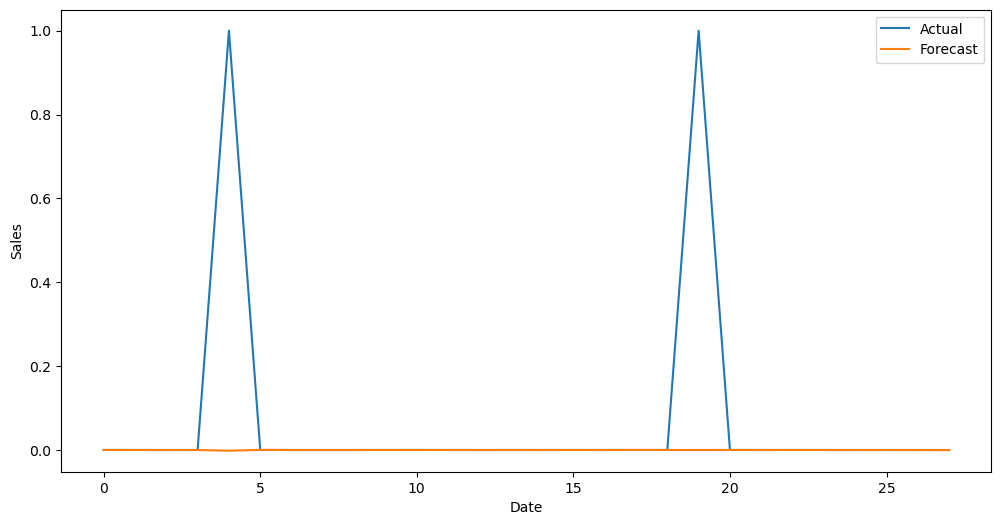

In [37]:
import matplotlib.pyplot as plt
i = -1
plt.figure(figsize=(12, 6))
plt.plot(test_labels[i][-100:], label="Actual")
plt.plot(test_forecasts[i], label="Forecast")
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(loc="upper right")
plt.show()
plt.close()


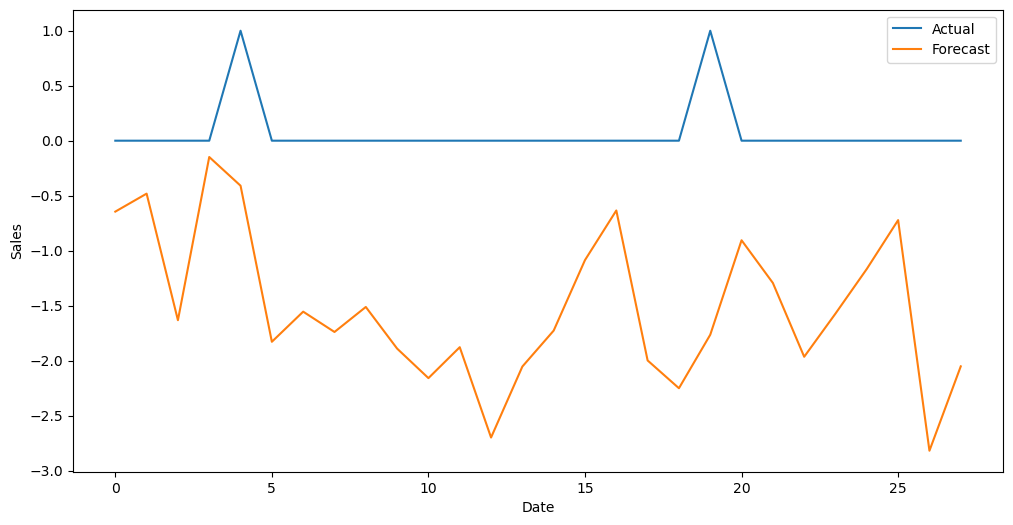

In [38]:
import matplotlib.pyplot as plt
i = -1
plt.figure(figsize=(12, 6))
plt.plot(test_labels[i][-100:], label="Actual")
plt.plot(test_forecasts_reconciled[i], label="Forecast")
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(loc="upper right")
plt.show()
plt.close()